# 掛載雲端硬碟

In [1]:
# import os
# from google.colab import drive

# drive.mount('/content/drive')

# os.chdir('/content/drive/MyDrive/Colab Notebooks/AI_CUP_DemoCode/TrainingData/')

# 載入套件

In [2]:
import numpy as np
import pandas as pd
import librosa

import tensorflow as tf
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score
from sklearn.utils import shuffle

# 模型架構

In [3]:
MODEL_SAVE_NAME = "AI_CUP_acoustic_sample_model"

# default hyperparameters
NEURONS = 300
HIDDEN_LAYERS = 3

def create_DNN(input_shape, neurons = NEURONS, hidden_layers = HIDDEN_LAYERS, learning_rate = 0.001, verbose=0):
    model = Sequential()

    model.add(Dense(neurons, input_dim=input_shape))
    model.add(Activation('sigmoid'))

    for i in range(hidden_layers-1):
        model.add(Dense(neurons))
        model.add(Activation('selu'))
        model.add(Dropout(0.3))

    model.add(Dense(5))
    model.add(Activation('softmax'))

    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    if verbose:
        model.summary()
    
    return model


# def create_DNN(input_shape, learning_rate = 0.001, dropout_rate = 0.1, verbose=0):
#     model = Sequential()

#     model.add(Dense(512, input_dim=input_shape))
#     model.add(Activation('relu'))
#     model.add(Dropout(dropout_rate))
    
#     model.add(Dense(256, input_dim=input_shape))
#     model.add(Activation('selu'))
#     model.add(Dropout(dropout_rate))
    
#     model.add(Dense(128, input_dim=input_shape))
#     model.add(Activation('selu'))
#     model.add(Dropout(dropout_rate))

#     model.add(Dense(64, input_dim=input_shape))
#     model.add(Activation('selu'))
#     model.add(Dropout(dropout_rate))

#     model.add(Dense(32, input_dim=input_shape))
#     model.add(Activation('selu'))
#     model.add(Dropout(dropout_rate))
    
#     model.add(Dense(5))
#     model.add(Activation('softmax'))

#     opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#     model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) # categorical_crossentropy

#     if verbose:
#         model.summary()
    
#     return model

In [4]:
source_df = pd.read_csv('./Training_Dataset/training_datalist.csv')
source_df2 = pd.read_csv('./Training_Dataset/training_datalist2.csv')

# 載入訓練資料

In [5]:
# 讀取訓練資料集表單
source_df = pd.read_csv('./Training_Dataset/training_datalist.csv')
source_df = pd.concat([source_df,source_df2])
print("source_df.shape :", source_df.shape)
print("source_df.columns :", source_df.columns)

source_df.shape : (1160, 28)
source_df.columns : Index(['ID', 'Sex', 'Age', 'Disease category', 'Narrow pitch range',
       'Decreased volume', 'Fatigue', 'Dryness', 'Lumping', 'heartburn',
       'Choking', 'Eye dryness', 'PND', 'Smoking', 'PPD', 'Drinking',
       'frequency', 'Diurnal pattern', 'Onset of dysphonia ', 'Noise at work',
       'Occupational vocal demand', 'Diabetes', 'Hypertension', 'CAD',
       'Head and Neck Cancer', 'Head injury', 'CVA',
       'Voice handicap index - 10'],
      dtype='object')


# 資料前處理

In [6]:
# 挑選出要訓練的Disease category 1、2、3、4、5
source_df = source_df.loc[source_df['Disease category'].isin([1, 2, 3, 4, 5]), ['ID', 'Disease category']]

# 在dataframe中加入要訓練的音檔路徑
source_df['wav_path'] = source_df['ID'].map("./Training_Dataset/training_voice_data/{}.wav".format)

print("Disease category in source_df :", source_df['Disease category'].unique())
print("source_df :\n", source_df)

Disease category in source_df : [1 2 3 5 4]
source_df :
             ID  Disease category   
0      1202f15                 1  \
1      0600ve0                 2   
2      1001o7l                 2   
3      1201c1t                 1   
4      0402jvt                 1   
..         ...               ...   
155  13028p5_2                 5   
156  13028p5_3                 5   
157  13028p5_4                 5   
158  13028p5_5                 5   
159  13028p5_6                 5   

                                              wav_path  
0    ./Training_Dataset/training_voice_data/1202f15...  
1    ./Training_Dataset/training_voice_data/0600ve0...  
2    ./Training_Dataset/training_voice_data/1001o7l...  
3    ./Training_Dataset/training_voice_data/1201c1t...  
4    ./Training_Dataset/training_voice_data/0402jvt...  
..                                                 ...  
155  ./Training_Dataset/training_voice_data/13028p5...  
156  ./Training_Dataset/training_voice_data/13028p5...

In [7]:
# dic = {'1':0, '2':0, '3':0, '4':0, '5':0}
# for i in range(len(source_df['Disease category'])):
#     if source_df['Disease category'][i] ==5:
#         dic['5']+=1
#     elif source_df['Disease category'][i] ==4:
#         dic['4']+=1
#     elif source_df['Disease category'][i] ==3:
#         dic['3']+=1
#     elif source_df['Disease category'][i] ==2:
#         dic['2']+=1
#     elif source_df['Disease category'][i] ==1:
#         dic['1']+=1
# dic


## 訓練與驗證資料切分

In [8]:
training_df, test_df = train_test_split(source_df, test_size=0.2, random_state=333)

print("training_df shape :", training_df.shape, ", test_df shape :", test_df.shape)

training_df shape : (928, 3) , test_df shape : (232, 3)


# 訓練聲學特徵

## 聲學音檔轉換MFCC特徵與訓練

In [9]:
# define function
def audio_to_mfccs(filename, sample_rate=44100, offset=0, duration=None):
    voice, sample_rate = librosa.load(filename, sr=sample_rate, offset=offset, duration=duration)
    
    n_fft = int(16/1000 * sample_rate)  # Convert 16 ms to samples
    hop_length = int(8/1000 * sample_rate)  # Convert 8 ms to samples
    mfcc_feature = librosa.feature.mfcc(y=voice, sr=sample_rate, n_mfcc=13, n_fft=n_fft, hop_length=hop_length)
    
    # mfccs_cvn = (mfcc_feature - np.mean(mfcc_feature, axis=1, keepdims=True)) / np.std(mfcc_feature, axis=1, keepdims=True)
    delta_mfcc_feature = librosa.feature.delta(mfcc_feature)
    
    mfccs = np.concatenate((mfcc_feature, delta_mfcc_feature))
    mfccs_features = np.transpose(mfccs)  # all frames

    return mfccs_features

In [10]:
training_id = training_df['ID'].tolist()
training_data = pd.DataFrame()
for id in training_id:

    mfccs_feature = audio_to_mfccs(training_df[training_df['ID']==id]['wav_path'].values[0])
    df = pd.DataFrame(mfccs_feature)
    # print("id :",id, ", number of frames :", df.shape[0])

    # 訓練資料標記
    label = training_df[training_df['ID']==id]['Disease category'].values[0]
    if label==1:
        df['c1'] = 1; df['c2'] = 0; df['c3'] = 0; df['c4'] = 0; df['c5'] = 0
    elif label==2:
        df['c1'] = 0; df['c2'] = 1; df['c3'] = 0; df['c4'] = 0; df['c5'] = 0
    elif label==3:
        df['c1'] = 0; df['c2'] = 0; df['c3'] = 1; df['c4'] = 0; df['c5'] = 0
    elif label==4:
        df['c1'] = 0; df['c2'] = 0; df['c3'] = 0; df['c4'] = 1; df['c5'] = 0
    elif label==5:
        df['c1'] = 0; df['c2'] = 0; df['c3'] = 0; df['c4'] = 0; df['c5'] = 1
    else:
        df['c1'] = np.nan; df['c2'] = np.nan; df['c3'] = np.nan; df['c4'] = np.nan; df['c5'] = np.nan

    training_data = pd.concat([training_data, df])

print("training_data.shape :", training_data.shape)

x_train = training_data.iloc[:, :-5]
y_train = training_data.iloc[:, -5:]
print("x_train.shape, y_train.shape :", x_train.shape, y_train.shape)
print("y_train.columns :", y_train.columns.tolist())

training_data.shape : (295761, 31)
x_train.shape, y_train.shape : (295761, 26) (295761, 5)
y_train.columns : ['c1', 'c2', 'c3', 'c4', 'c5']


In [11]:
test_id = test_df['ID'].tolist()
test_data = pd.DataFrame()
for id in test_id:
#     print(id)
    mfccs_feature = audio_to_mfccs(test_df[test_df['ID']==id]['wav_path'].values[0])
    df = pd.DataFrame(mfccs_feature)
    # print("id :",id, ", number of frames :", df.shape[0])

    # 訓練資料標記
    label = test_df[test_df['ID']==id]['Disease category'].values[0]
    if label==1:
        df['c1'] = 1; df['c2'] = 0; df['c3'] = 0; df['c4'] = 0; df['c5'] = 0
    elif label==2:
        df['c1'] = 0; df['c2'] = 1; df['c3'] = 0; df['c4'] = 0; df['c5'] = 0
    elif label==3:
        df['c1'] = 0; df['c2'] = 0; df['c3'] = 1; df['c4'] = 0; df['c5'] = 0
    elif label==4:
        df['c1'] = 0; df['c2'] = 0; df['c3'] = 0; df['c4'] = 1; df['c5'] = 0
    elif label==5:
        df['c1'] = 0; df['c2'] = 0; df['c3'] = 0; df['c4'] = 0; df['c5'] = 1
    else:
        df['c1'] = np.nan; df['c2'] = np.nan; df['c3'] = np.nan; df['c4'] = np.nan; df['c5'] = np.nan

    test_data = pd.concat([test_data, df])

print("training_data.shape :", test_data.shape)

x_val = test_data.iloc[:, :-5]
y_val = test_data.iloc[:, -5:]
print("x_val.shape, y_val.shape :", x_val.shape, y_val.shape)
print("y_val.columns :", y_val.columns.tolist())

print("x_val.shape, y_val.shape :", x_val.shape, y_val.shape)

training_data.shape : (74047, 31)
x_val.shape, y_val.shape : (74047, 26) (74047, 5)
y_val.columns : ['c1', 'c2', 'c3', 'c4', 'c5']
x_val.shape, y_val.shape : (74047, 26) (74047, 5)


In [12]:
model = create_DNN(input_shape = x_train.shape[1], verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               8100      
                                                                 
 activation (Activation)     (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 300)               90300     
                                                                 
 activation_1 (Activation)   (None, 300)               0         
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 300)               90300     
                                                                 
 activation_2 (Activation)   (None, 300)               0

In [13]:
# train_results = model.fit(x_train, y_train, batch_size=256, epochs=100, 
#                             callbacks=[EarlyStopping(monitor='val_loss', patience=5, mode='auto'),
#                                         ModelCheckpoint(MODEL_SAVE_NAME+".h5", save_best_only=True)], 
#                             validation_data=(x_val, y_val))

train_results = model.fit(x=x_train,  
                          y=y_train, validation_split=0.1,  
                          epochs=10, batch_size=300, verbose=2,callbacks=[EarlyStopping(monitor='val_loss', patience=5, mode='auto'),
                                        ModelCheckpoint(MODEL_SAVE_NAME+".h5", save_best_only=True)],validation_data=(x_val, y_val))

Epoch 1/10
986/986 - 5s - loss: 0.7212 - accuracy: 0.7262 - val_loss: 1.2204 - val_accuracy: 0.5750 - 5s/epoch - 5ms/step
Epoch 2/10
986/986 - 4s - loss: 0.4841 - accuracy: 0.8181 - val_loss: 1.3862 - val_accuracy: 0.5694 - 4s/epoch - 4ms/step
Epoch 3/10
986/986 - 4s - loss: 0.4214 - accuracy: 0.8434 - val_loss: 1.3755 - val_accuracy: 0.5750 - 4s/epoch - 5ms/step
Epoch 4/10
986/986 - 5s - loss: 0.3918 - accuracy: 0.8548 - val_loss: 1.4423 - val_accuracy: 0.5667 - 5s/epoch - 5ms/step
Epoch 5/10
986/986 - 5s - loss: 0.3721 - accuracy: 0.8626 - val_loss: 1.4448 - val_accuracy: 0.5840 - 5s/epoch - 5ms/step
Epoch 6/10
986/986 - 5s - loss: 0.3581 - accuracy: 0.8680 - val_loss: 1.4983 - val_accuracy: 0.5649 - 5s/epoch - 5ms/step


## 訓練資料預測結果

12/12 [==============================] - 0s 1ms/step


12/12 [==============================] - 0s 909us/step


8/8 [==============================] - 0s 1ms/step


8/8 [==============================] - 0s 1ms/step


12/12 [==============================] - 0s 1ms/step


16/16 [==============================] - 0s 933us/step


8/8 [==============================] - 0s 1ms/step
Training UAR(Unweighted Average Recall) : 0.9457838281121864


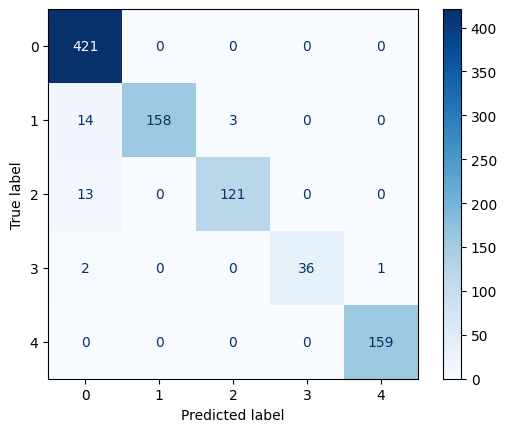

In [14]:
y_true = training_df['Disease category'] - 1  # 將[1,2,3,4,5]轉換為[0,1,2,3,4]
y_pred = []
for id in training_id:
    mfccs_feature = audio_to_mfccs(training_df[training_df['ID']==id]['wav_path'].values[0])
    df = pd.DataFrame(mfccs_feature)

    frame_pred = model.predict(df)
    frame_pred_results = frame_pred.argmax(axis=1)

    person_pred = np.array([np.sum(frame_pred_results==0), np.sum(frame_pred_results==1), np.sum(frame_pred_results==2), np.sum(frame_pred_results==3), np.sum(frame_pred_results==4)]).argmax()  # 注意!如三類別相同票數，預測會為0

    y_pred.append(person_pred)

results_recall = recall_score(y_true, y_pred, average=None)
print("Training UAR(Unweighted Average Recall) :", results_recall.mean())

ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(cmap='Blues')

# 驗證資料測試結果

8/8 [==============================] - 0s 1ms/step


8/8 [==============================] - 0s 1ms/step
Test UAR(Unweighted Average Recall) : 0.5139032266397996


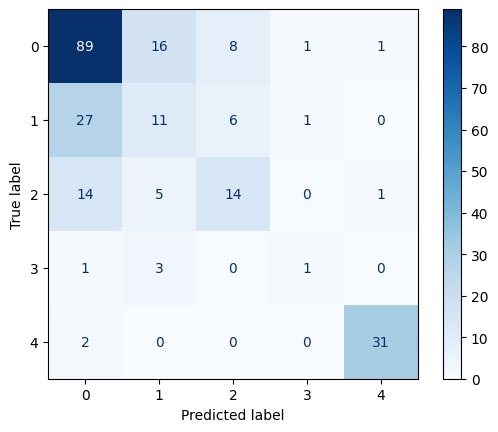

In [15]:
# model = load_model(MODEL_SAVE_NAME + ".h5")

y_true = test_df['Disease category'] - 1  # 將[1,2,3,4,5]轉換為[0,1,2,3,4]
y_pred = []
for id in test_df['ID'].tolist():
    mfccs_feature = audio_to_mfccs(test_df[test_df['ID']==id]['wav_path'].values[0])
    df = pd.DataFrame(mfccs_feature)

    frame_pred = model.predict(df)
    frame_pred_results = frame_pred.argmax(axis=1)

    person_pred = np.array([np.sum(frame_pred_results==0), np.sum(frame_pred_results==1), np.sum(frame_pred_results==2), np.sum(frame_pred_results==3), np.sum(frame_pred_results==4)]).argmax()  # 注意!如三類別相同票數，預測會為0

    y_pred.append(person_pred)
    # print(np.array([np.sum(frame_pred_results==0), np.sum(frame_pred_results==1), np.sum(frame_pred_results==2)]))
    # print(frame_pred)

results_recall = recall_score(y_true, y_pred, average=None)
print("Test UAR(Unweighted Average Recall) :", results_recall.mean())

ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(cmap='Blues')

#加入nomal audio的augmentation UAR:0.51